## Heisenberg-limit algorithm for ground state energy estimation

In [1]:
# general imports
import numpy as np
import math
import mpmath as mp
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter


from braket.circuits import Circuit, circuit, Instruction
from braket.devices import LocalSimulator

from braket.tracking import Tracker



In [2]:
tracker = Tracker().start()
device = LocalSimulator()

In [47]:
mp.mp.dps = 20

## Fermi-Hubbard Model

$$
H = -\frac{t}{2} \sum_{j,\sigma}(X_{j,\sigma}X_{j+1,\sigma}+Y_{j,\sigma}Y_{j+1,\sigma}) + \frac{U}{4} \sum_j Z_{j,\uparrow}Z_{j,\downarrow}
$$

We wanna find the ground state energy of it.

In [210]:
hubbard = fermi_hubbard(1, 4, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

#plt.matshow(fh_matrix)

### Why $\tau$?

We need to normalize $H$ such that all its eigenvalue fall in [$-\pi/3$, $\pi/3$]. 

In [211]:
norm = np.linalg.norm(fh_matrix)
tau = 3*np.pi/(4*norm)

10

In [158]:
int('10011001', 2)
int('01100110', 2)

102

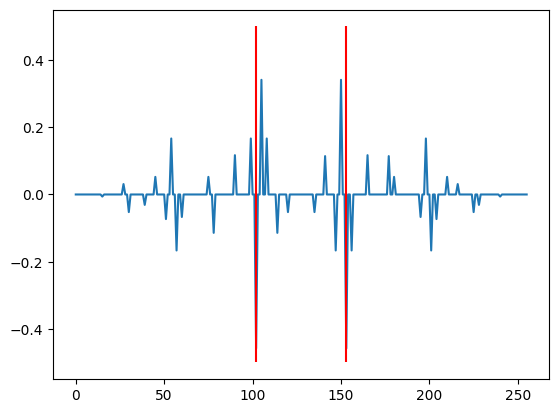

In [166]:
energy, eigenstate = np.linalg.eig(fh_matrix)


plt.plot(eigenstate[:,1])
## Peak value: -0.458
plt.vlines(x=102,ymin=-.5,ymax=.5,colors='r') ## 01100110
plt.vlines(x=153,ymin=-.5,ymax=.5,colors='r') ## 10011001

### Cumulative Distribution Function(CDF) for H

Given a initial state $\rho$, we can find the CDF for H, which is a ladder-like function from 0 t0 1. We choose the Hatree Fock state as the initial state(one occupation on each site and opposite spin for neighboring occupations).

In [213]:
def get_real_CDF(N_sites, t, U, tau, precision):

    hubbard = fermi_hubbard(1, N_sites, t, U, periodic=False,particle_hole_symmetry=True)
    jw_hamiltonian = jordan_wigner(hubbard)
    fh_matrix = get_sparse_operator(jw_hamiltonian)
    fh_matrix = fh_matrix.todense()
    fh_matrix = fh_matrix.real
    norm = np.linalg.norm(fh_matrix)
    #tau = np.pi/(4*norm)
    
    Ndim = 2**(2*N_sites)
    energy, eigenstate= np.linalg.eig(tau*fh_matrix)

    hf_state = np.zeros(Ndim)
    # hf_index = 0
    # for i in range(N_sites):
    #     if i%2==0:
    #         hf_index += 2**(2*i)
    #     elif i%2!=0:
    #         hf_index += 2**(2*i+1)
    # hf_state[hf_index] = 1

    index_1 = int('0110'*(N_sites//2),2)
    index_2 = int('1001'*(N_sites//2),2)
    hf_state[index_1], hf_state[index_2] = 1/np.sqrt(2), 1/np.sqrt(2)

    energy=energy.real
    eigenstate[np.abs(eigenstate)<1e-10]=0
    eigenstate = np.array(eigenstate)

    prob_raw = np.zeros(Ndim)
    for i in range(Ndim):
        prob_raw[i] = np.abs(np.dot(hf_state,eigenstate[:,i]))**2
    prob = []
    ener = []
    for i,ele in enumerate(prob_raw):
        if ele!=0:
            prob.append(ele)
            ener.append(energy[i].real)

    x_list = np.linspace(-np.pi/3, np.pi/3, precision)
    CDF = np.zeros(len(x_list))

    for j,ener_ele in enumerate(ener):
        for i,x_ele in enumerate(x_list):
            if x_ele>ener_ele:
                CDF[i] += prob[j]

    return CDF

10 10 10 10

(-0.5, 1.5)

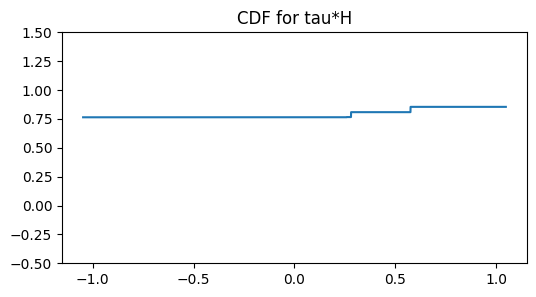

In [269]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(np.linspace(-np.pi/3, np.pi/3, 10000), get_real_CDF(4, 1, 4, 1, 10000))
ax.set_title('CDF for tau*H')
ax.set_ylim([-0.5, 1.5])


In [214]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step):
    
    qc = Circuit()
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.xx(2*i,2*i+1,theta)
            qc.yy(2*i,2*i+1,theta)

            qc.xx(2*i+N_sites,2*i+1+N_sites,theta)
            qc.yy(2*i+N_sites,2*i+1+N_sites,theta)
            
        for i in range((N_sites-1)//2):
            qc.xx(2*i+1,2*i+2,theta)
            qc.yy(2*i+1,2*i+2,theta)

            qc.xx(2*i+N_sites+1,2*i+2+N_sites,theta)
            qc.yy(2*i+N_sites+1,2*i+2+N_sites,theta)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.zz(i,i+N_sites,gamma)
    return qc

In [215]:
#print(fh_evolution(4, 1, 2, 0.5, 1, 1))

In [9]:
def czz_gate(angle):
    qc = Circuit()
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    
    return qc

def cxx_gate(angle):
    qc = Circuit()
    qc.h([1,2])
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.h([1,2])
    return qc

def cyy_gate(angle):
    qc = Circuit()
    qc.rx([1,2],pi/2)
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.rx([1,2],-pi/2)
    
    return qc

In [10]:
# ## Get circuit for Hadamard Test

# ## This function doesn't work properly! Please use get_new_Hadamard_circuit
# ##

# def get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    
#     num_qubits = 2*N_sites+1
#     qc = Circuit()
    
#     qc.h(0)
    
#     ## State Initialization
#     for i in range(N_sites):
#         if i%2!=0:
#             qc.x(i+1)
#         else:
#             qc.x(i+1+N_sites)
            
#     ## Control-Evolution Gate
    
#     for _ in range(step):
        
#         ## Hopping terms 
#         theta = tau*t*j/step    
#         for i in range(N_sites//2):
#             #qc.cxx(num_qubits-1,[2*i,2*i+1],theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+1, 2*i+2])
            
#             #qc.cyy(num_qubits-1,[2*i,2*i+1],theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+1, 2*i+2])
            
#             #qc.cxx(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])
            
#             #qc.cyy(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])

            
            
#         for i in range((N_sites-1)//2):
#             #qc.cxx(num_qubits-1,[2*i+1,2*i+2],theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+2, 2*i+3])
            
#             #qc.cyy(num_qubits-1,[2*i+1,2*i+2],theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+2, 2*i+3])
            
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
        
#         ## Potential terms
#         gamma = tau*U*j/(2*step)
#         for i in range(N_sites):
#             qc.add_circuit(czz_gate(gamma),[0, i+1, i+1+N_sites])
    
#     if test_type=='real':
#         pass
#     elif test_type=='imag':
#         qc.si(0)
    
#     qc.h(0)
    
#     qc.probability(target=0)
#     return qc


(array([ 90, 165]),)

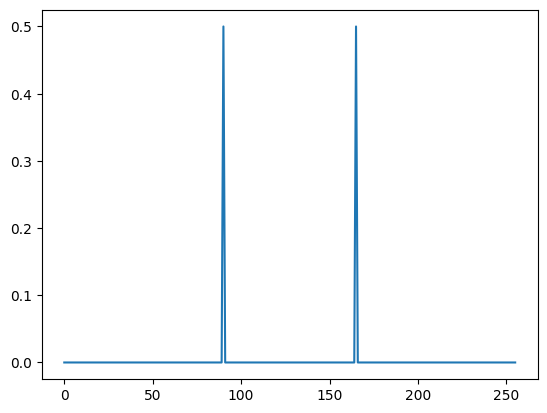

In [353]:
qc = Circuit()
N_sites=4
## Control-UI gate (Symmetric initial state)
qc.x([0,1])

for i in range(N_sites):
    if i%2!=0:
        qc.x(i+2)
    else:
        qc.x(i+2+N_sites)

## CH(0, 2)
qc.ry(2, -pi/4)
qc.z(2)
qc.ry(2, pi/4)    

for i in range(2*N_sites-1):
    qc.cnot(2, i+3)


# ## Control-UI_dagger gate(Sym)
# for i in range(2*N_sites-1):
#     qc.cnot(2, i+3)    

# qc.ry(2, -pi/4)
# qc.z(2)
# qc.ry(2, pi/4)

# for i in range(N_sites):
#     if i%2!=0:
#         qc.x(i+2)
#     else:
#         qc.x(i+2+N_sites)

qc.probability(target=range(2,10))
res = device.run(qc, shots=0).result()

prob = res.values[0]
plt.plot(res.values[0])
np.nonzero(prob)

In [355]:
bin(165)

'0b10100101'

In [216]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    num_qubits = 2*N_sites+2
    qc = Circuit()

    qc.h([0,1])

    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    # # Control-UI gate
    # for i in range(N_sites):
    #     if i%2!=0:
    #         qc.cnot(0,i+2)
    #     else:
    #         qc.cnot(0, i+2+N_sites)


    ## Control-UI gate (Symmetric initial state)
    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(0,i+2)
        else:
            qc.cnot(0, i+2+N_sites)

    ## CH(0, 2)
    qc.ry(2, -pi/4)
    qc.cz(0, 2)
    qc.ry(2, pi/4)    

    for i in range(2*N_sites-1):
        qc.ccnot(0,2, i+3)

    
    ## Control-UR gate, but pass

    ## evolution
    qc.add_circuit(fh_evolution(N_sites, t, U, tau, j, step), range(2,num_qubits))

    # ## Control-UI_dagger gate
    # for i in range(N_sites):
    #     if i%2!=0:
    #         qc.cnot(1,i+2)
    #     else:
    #         qc.cnot(1, i+2+N_sites)

    ## Control-UI_dagger gate(Sym)
    for i in range(2*N_sites-1):
        qc.ccnot(1,2, i+3)    

    qc.ry(2, -pi/4)
    qc.cz(1, 2)
    qc.ry(2, pi/4)

    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(1,i+2)
        else:
            qc.cnot(1, i+2+N_sites)


    
    
    qc.h([0,1])

    qc.probability(target=range(num_qubits))
    return qc

In [217]:
#print(get_new_Hadamard_circuit(4,1,4,1,1,1))

In [12]:
job = device.run(get_new_Hadamard_circuit(4, 1, 4, 0.5, 1, 1),shots=1000)
res = job.result()

In [218]:
def get_new_Z(N_sites, t, U, tau, j, step, shots):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')

    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()

    probs_real = res_real.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_real.keys():
        p00 = probs_real['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_real.keys():
        p01 = probs_real['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_real.keys():
        p10 = probs_real['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_real.keys():
        p11 = probs_real['11'+'0'*2*N_sites]
        
    X = p00+p11-p01-p10 

    probs_imag = res_imag.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_imag.keys():
        p00 = probs_imag['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_imag.keys():
        p01 = probs_imag['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_imag.keys():
        p10 = probs_imag['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_imag.keys():
        p11 = probs_imag['11'+'0'*2*N_sites]
    
    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

In [239]:
get_new_Z(4,1,4,1,1,1,100000)

(-0.11728914175193575-0.12669791642759692j)

## Calculate Fourier coefficient for step Function

$$
F = \frac{1}{2} + \sum_j F_j (e^{ijx} - e^{-ijx})
$$

Notice that $F_j=0$ for all even $j$. Therefore,

$$
F = \frac{1}{2} + \sum^d_{j=0} F_j (e^{i(2j+1)x} - e^{-i(2j+1)x})
$$

From the Appendix of the PRL paper, 

$$
F_j = -i\sqrt{\frac{\beta}{2\pi}}e^{-\beta}*\frac{I_v(j, \beta)+I_v(j+1, \beta)}{2j+1}
$$

In [16]:
def get_F(beta, j):
    
    F = -1j*np.sqrt(beta/(2*pi))*np.exp(-beta)*(iv(j,beta)+iv(j+1,beta))/(2*j+1)

    return F

In [17]:
def get_F_coefs(d, beta):
    F_list = np.zeros(d+1,dtype='complex128')
    
    for j in range(d):
        F_list[j] = get_F(beta, j)
    
    F_list[d] = -1j*np.sqrt(.5*beta/pi) * np.exp(-beta) * iv(d,beta)/(2*d+1)
    
    return F_list

In [18]:
def get_approx_step_function(d, beta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_F_coefs(d, beta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real

We plot out the approximated step function.

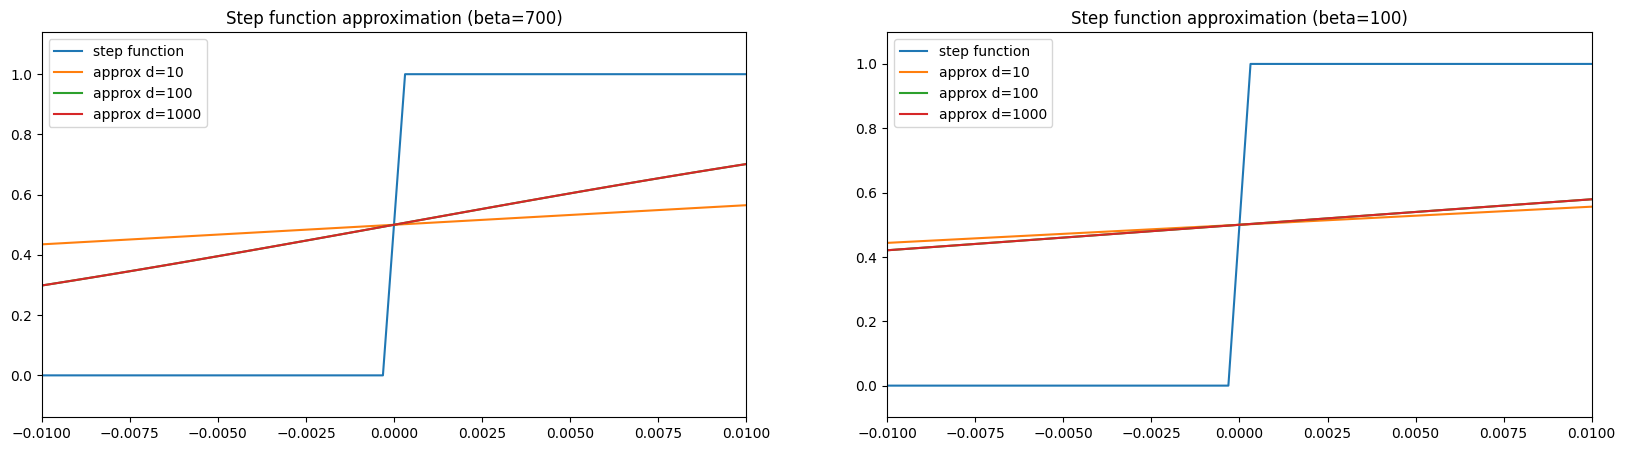

In [138]:
x_list = np.linspace(-pi,pi,10000)
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[0].plot(x_list,get_approx_step_function(d=10,beta=700),label='approx d=10')
ax[0].plot(x_list,get_approx_step_function(d=100,beta=700),label='approx d=100')
ax[0].plot(x_list,get_approx_step_function(d=1000,beta=700),label='approx d=1000')
ax[0].set_title('Step function approximation (beta=700)')
ax[0].legend()
ax[0].set_xlim([-.01,.01])

ax[1].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[1].plot(x_list,get_approx_step_function(d=10,beta=100),label='approx d=10')
ax[1].plot(x_list,get_approx_step_function(d=100,beta=100),label='approx d=100')
ax[1].plot(x_list,get_approx_step_function(d=1000,beta=100),label='approx d=1000')
ax[1].set_title('Step function approximation (beta=100)')
ax[1].set_xlim([-.01,.01])
ax[1].legend()

### Another way to calculate F

In [241]:


def get_M(x,d,delta):

    def get_Tn(x,n):
        coef = np.zeros(n+1)
        coef[n] = 1
        return np.polynomial.chebyshev.chebval(x = x, c=coef)
    def integrand(x):
        temp = (np.cos(x) - np.cos(delta))/(1 + np.cos(delta) )
        #temp = (mp.cos(x) - mp.cos(delta))/(1 + mp.cos(delta))
        S = (1 + 2 * temp )
        return get_Tn(x=S,n=d)


    N, e = integrate.quad(integrand,-np.pi,np.pi, limit=d, points = np.linspace(-np.pi,np.pi,d))
    print('error is', e)
    #N = mp.quad(integrand, [-pi, pi])
    
    return integrand(x)/N

def get_new_F_coefs(d, delta):

    d = d*2+2
    def get_M_fourier(d,delta):
        x = np.arange(-np.pi,np.pi,np.pi/(2*d))

        M_list = get_M(x,d,delta)
        # M_list = []
        # for ele in x:
        #      M_list.append(get_M(ele,d,delta))
        x_ft = np.fft.fft(M_list)/(4*d)
        
        for i,ele in enumerate(x_ft):
            x_ft[i]*=(-1)**i

        return x_ft

    def get_H_fourier(k):
        if k%2 ==0 and k!=0:
            return 0
        elif k==0:
            return np.sqrt(np.pi/2)
        elif k%2 !=0:
            return -1j*2/(np.sqrt(2*np.pi)*k)   

    x = np.arange(-np.pi,np.pi,np.pi/d)
    #M = get_M(x=x,d=d,delta=delta)
    M_fourier = get_M_fourier(d,delta)
    M_fourier = M_fourier[0:d+1]
    H_fourier = np.array([get_H_fourier(k) for k in range(d+1)])
    F = np.sqrt(2*np.pi) * M_fourier *H_fourier

    F_odd = [1j*F[2*i+1].imag for i in range(d//2)]
    return F_odd

In [195]:
def get_new_approx_step_function(d, delta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_new_F_coefs(d, delta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real

def get_step_from_F(F_list):

    d = len(F_list)-1
    x_list = np.linspace(-pi,pi, 10000)
    F_approx = 0.5*np.ones(len(x_list))
    for j, F in enumerate(F_list):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    return F_approx.real

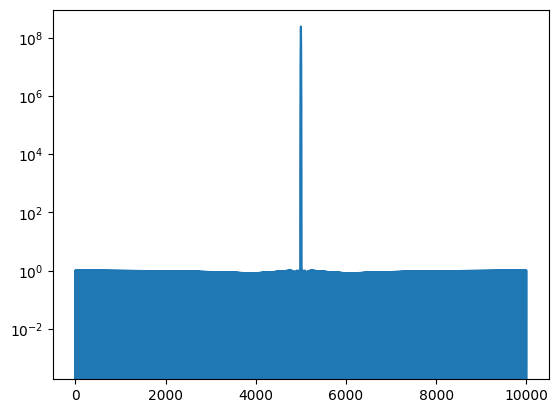

In [139]:
def get_Tn(x,n):
    coef = np.zeros(n+1)
    coef[n] = 1
    return np.polynomial.chebyshev.chebval(x = x, c=coef)
def integrand(x, delta, d):
    temp = (np.cos(x) - np.cos(delta))/(1 + np.cos(delta) )
    #temp = (mp.cos(x) - mp.cos(delta))/(1 + mp.cos(delta))
    S = (1 + 2 * temp )
    return get_Tn(x=S,n=d)

d=2000
plt.plot(integrand(x_list, 20/d, d))
plt.yscale('log')

In [193]:
#x_list = np.linspace(-pi,pi,20000)
#plt.plot(get_M(x_list,200,4/200))

In [144]:
M_list = []
x_list = np.linspace(-pi,pi,10000)
# for ele in x_list:
#     M_list.append(get_M(ele,2000,0.01))

plt.plot(get_M(x_list,d,20/d))
plt.yscale('log')

KeyboardInterrupt: 

In [190]:

F_list_import =np.load('F_list.npy')

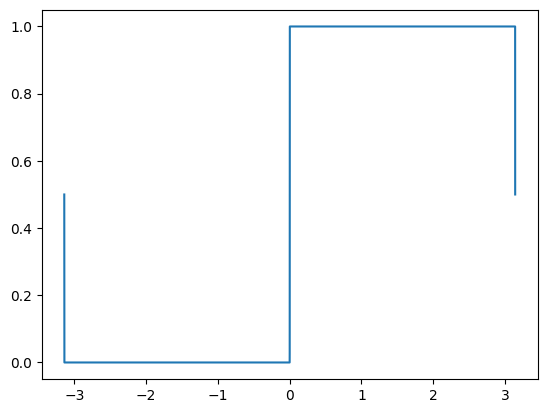

In [197]:
x_list = np.linspace(-pi,pi,10000)


In [242]:
A = get_new_approx_step_function(2000,.003)
#B = get_new_approx_step_function(6000,.002)

error is 1.2318831295862656e-10


/var/folders/8s/46j41bsj6rq3xkzplbcmjm2h0000gn/T/ipykernel_41461/476835642.py:14: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N, e = integrate.quad(integrand,-np.pi,np.pi, limit=100, points = np.linspace(-np.pi,np.pi,100))


error is 0.4930483771155578


(-0.001, 0.001)

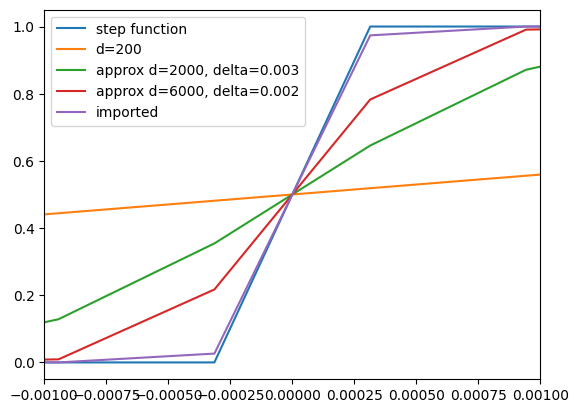

In [200]:
x_list = np.linspace(-pi,pi,10000)
plt.plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
#plt.plot(np.linspace(-pi,pi,10000), get_new_approx_step_function(20,.1))
plt.plot(np.linspace(-pi,pi,10000), get_new_approx_step_function(200,.02),label='d=200')
plt.plot(np.linspace(-pi,pi,10000), A,label='approx d=2000, delta=0.003')
plt.plot(np.linspace(-pi,pi,10000), B,label='approx d=6000, delta=0.002')
#plt.plot(np.linspace(-pi,pi,10000), get_new_approx_step_function(2000,.0001),label='approx d=6000, delta=0.002')
plt.plot(x_list,get_step_from_F(F_list_import),label='imported')
plt.legend()

plt.xlim([-.001, .001])

In [20]:
## Use the get_new_Z instead.

# def get_Z(N_sites, t, U, tau, j, step, shots):
    
#     qc_real = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
#     qc_imag = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')
    
#     device = LocalSimulator()
#     job_real = device.run(qc_real, shots=shots)
#     job_imag = device.run(qc_imag, shots=shots)
#     res_real = job_real.result()
#     res_imag = job_imag.result()
#     prob_real = res_real.values[0]
#     prob_imag = res_imag.values[0]
    
#     Z = (prob_real[0]-prob_real[1])+1j*(prob_imag[0]-prob_imag[1])
    
#     return Z

### Shots allocation
We don't evaluate each term in the expression of ACDF with the same amount of shots. Rather, we allocate shots to terms with more weights. The weight will be the absolute value of $F_j$.

In [219]:
def get_shots_per_run(F_list, total_shots):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
    counter = Counter(sampling)

    shots_list = np.zeros(len(probs),dtype=int)
    for i in range(len(probs)):
        shots_list[i] = int(counter[i])

    #shots_per_run = np.round(total_shots*probs)
    return shots_list#shots_per_run

In [220]:
def get_Z_list(d, N_sites, t, U, tau, step, shots_list): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j])
    return Z_list

\begin{equation}
ACDF(x) = 0.5+\sum^d_{j=0} F_j e^{i(2j+1)x} Z_j
\end{equation}


In [221]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list) - F_list[j]*Z_list[j].conj()*np.exp(-1j*(2*j+1)*x_list)
        #ACDF = ACDF + F_list[j]*Z_list[j]*2j*np.sin((2*j+1)*x_list)
                                                                              
    return ACDF

In [231]:
F_list_import =np.load('F_list_d2e4_lim1e4.npy')

In [232]:
#F_list = get_F_coefs(d=200, beta=500)
#F_list = get_new_F_coefs(2000, 0.003)
#F_list = get_new_F_coefs(200, 0.02)
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=1e4)
Z_list = get_Z_list(20000, 4, 1, 4, tau, 4, shots_list)
#Z_list_2 = get_Z_list(200, 4, 1, 4, tau, 4, int(1e2))
ACDF = Assembly_ACDF(Z_list, F_list_import, 100000)
#ACDF_2 = Assembly_ACDF(Z_list_2, F_list, 10000)

(-1.0471975511965976, 1.0471975511965976)

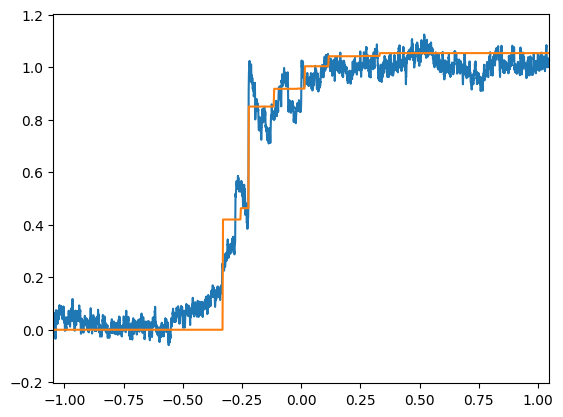

In [233]:
plt.plot(np.linspace(-pi,pi,100000), ACDF)
#plt.plot(np.linspace(-pi,pi,10000), ACDF_2)
plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4, tau,precision=1000), label='CDF')
plt.xlim([-pi/3, pi/3])

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 0.4)

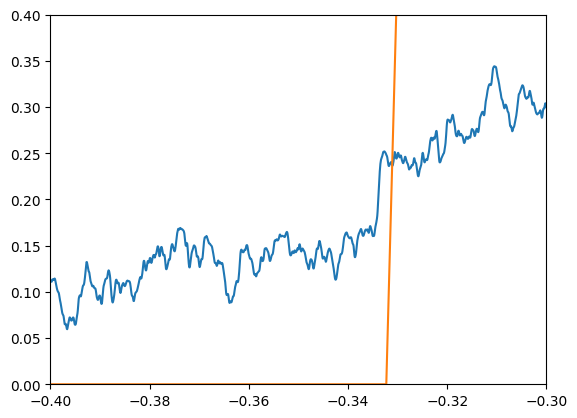

In [236]:
plt.plot(np.linspace(-pi,pi,100000), ACDF)
plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4, tau,precision=1000), label='CDF')
#plt.ylim([-0.5, 1.5])
#plt.xlim([-1.2, 1.2])
plt.xlim([-0.4,-0.3])
plt.ylim([0,0.4])